# UNet
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *


from pathlib import Path
import random

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [4]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [5]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [6]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [8]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [9]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [10]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [11]:
transforms2=Compose([],p=1)

In [12]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [14]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [15]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [16]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [17]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

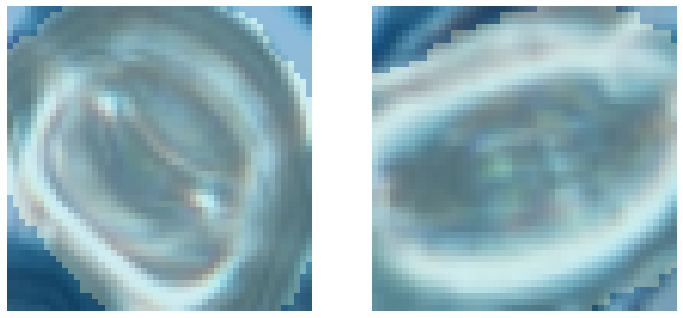

In [18]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = unet_learner(trainDLS, resnet18, metrics=[Dice(),JaccardCoeff()], wd=1e-2).to_fp16()
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/UNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

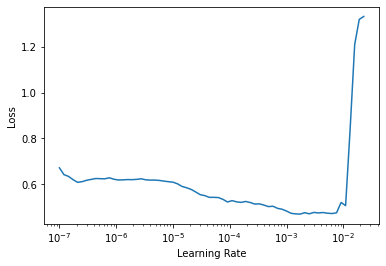

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.231373,0.258894,0.941542,0.889541,04:36
1,0.214428,0.220643,0.947002,0.899338,04:34
2,0.189543,0.212995,0.948600,0.902226,04:38
3,0.198378,0.192364,0.950493,0.905656,04:39
4,0.185818,0.190264,0.949004,0.902956,04:39
5,0.180336,0.182884,0.953192,0.910570,04:39
6,0.192818,0.183801,0.951651,0.907762,04:38
7,0.187832,0.182557,0.952808,0.909870,04:38
8,0.181448,0.177278,0.953672,0.911447,04:33
9,0.194277,0.177124,0.953904,0.911870,04:31


Better model found at epoch 0 with valid_loss value: 0.2588943541049957.


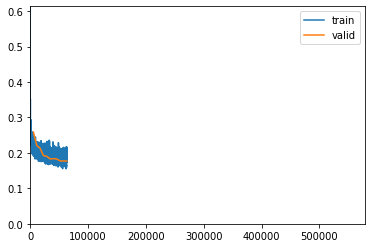

Better model found at epoch 1 with valid_loss value: 0.22064289450645447.
Better model found at epoch 2 with valid_loss value: 0.2129947543144226.
Better model found at epoch 3 with valid_loss value: 0.19236356019973755.
Better model found at epoch 4 with valid_loss value: 0.1902635544538498.
Better model found at epoch 5 with valid_loss value: 0.18288351595401764.
Better model found at epoch 7 with valid_loss value: 0.1825569123029709.
Better model found at epoch 8 with valid_loss value: 0.1772778183221817.
Better model found at epoch 9 with valid_loss value: 0.1771240383386612.
No improvement since epoch 9: early stopping


In [ ]:
name = "model_UNet_resnet18_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1771240383386612,0.9539038221138076,0.9118700959612772]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

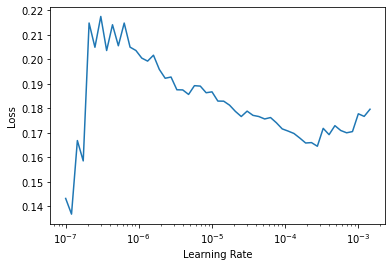

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.174304,0.172111,0.954924,0.913736,05:18
1,0.173790,0.170751,0.955493,0.914778,05:18
2,0.183932,0.170346,0.955591,0.914959,05:17
3,0.179384,0.173274,0.955004,0.913883,05:16
4,0.178991,0.173599,0.954822,0.913550,05:08


Better model found at epoch 0 with valid_loss value: 0.1721111238002777.


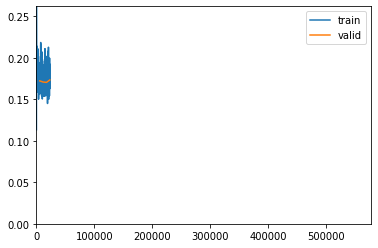

Better model found at epoch 1 with valid_loss value: 0.17075146734714508.
Better model found at epoch 2 with valid_loss value: 0.170345738530159.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_UNet_resnet18_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.170345738530159,0.9555909801637309,0.9149585670119337]



---


Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
del learn
learn = unet_learner(trainDLS, resnet18, metrics=[Dice(),JaccardCoeff()], wd=1e-1).to_fp16()
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/UNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

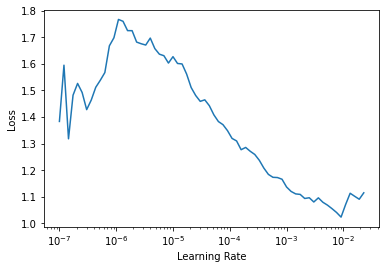

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.216647,0.233510,0.941979,0.890321,04:31
1,0.210241,0.218952,0.946409,0.898270,04:31
2,0.201970,0.204701,0.948336,0.901748,04:32
3,0.192927,0.199639,0.949725,0.904262,04:33
4,0.174159,0.214153,0.949216,0.903341,04:31
5,0.197783,0.182353,0.952256,0.908863,04:31
6,0.207844,0.190276,0.950671,0.905980,04:32
7,0.178600,0.178826,0.953242,0.910661,04:31
8,0.183658,0.179700,0.953741,0.911573,04:31
9,0.187138,0.176594,0.954020,0.912083,04:30


Better model found at epoch 0 with valid_loss value: 0.23351046442985535.


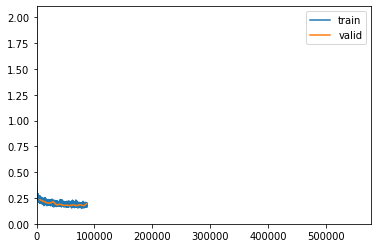

Better model found at epoch 1 with valid_loss value: 0.2189515084028244.
Better model found at epoch 2 with valid_loss value: 0.2047005444765091.
Better model found at epoch 3 with valid_loss value: 0.1996394693851471.
Better model found at epoch 5 with valid_loss value: 0.18235349655151367.
Better model found at epoch 7 with valid_loss value: 0.17882604897022247.
Better model found at epoch 9 with valid_loss value: 0.1765943169593811.
Better model found at epoch 11 with valid_loss value: 0.17611196637153625.
Better model found at epoch 13 with valid_loss value: 0.17427824437618256.
No improvement since epoch 13: early stopping


In [ ]:
name = "model_UNet_resnet18_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17427824437618256,0.9550932422864677,0.9140463828336274]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

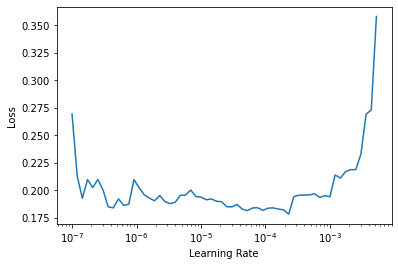

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).



epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.163680,0.170589,0.955721,0.915197,05:07
1,0.194764,0.167397,0.956553,0.916723,05:12
2,0.162975,0.169845,0.956167,0.916015,05:14
3,0.163141,0.168337,0.955732,0.915218,05:30


Better model found at epoch 0 with valid_loss value: 0.17058874666690826.


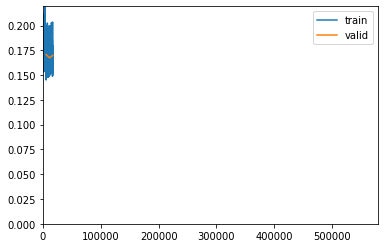

Better model found at epoch 1 with valid_loss value: 0.16739703714847565.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_UNet_resnet18_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16739703714847565,0.9565526365251305,0.9167234208533875]

# Modelos sin aumento de datos
Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
del learn
learn = unet_learner(trainDLS, resnet18, metrics=[Dice(),JaccardCoeff()], wd=1e-2).to_fp16()
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/UNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

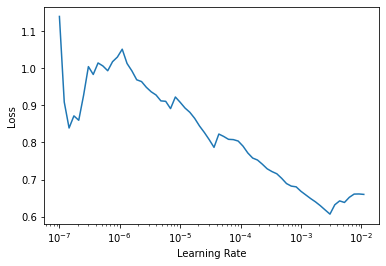

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.222303,0.216100,0.945438,0.896522,04:38
1,0.211879,0.202497,0.950103,0.904949,04:38
2,0.210640,0.191031,0.951630,0.907723,04:36
3,0.194494,0.188625,0.950034,0.904824,04:35
4,0.194639,0.177139,0.953967,0.911986,04:35
5,0.179303,0.188717,0.951728,0.907902,04:38
6,0.196546,0.176309,0.954085,0.912202,04:37
7,0.186210,0.179804,0.953638,0.911384,04:36
8,0.178639,0.181827,0.954359,0.912702,04:35


Better model found at epoch 0 with valid_loss value: 0.2160997986793518.


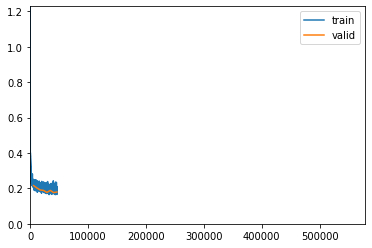

Better model found at epoch 1 with valid_loss value: 0.20249658823013306.
Better model found at epoch 2 with valid_loss value: 0.19103054702281952.
Better model found at epoch 3 with valid_loss value: 0.18862469494342804.
Better model found at epoch 4 with valid_loss value: 0.1771385371685028.
Better model found at epoch 6 with valid_loss value: 0.17630912363529205.
No improvement since epoch 6: early stopping


In [ ]:
name = "model_UNet_resnet18_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado

In [ ]:
learn.load("model_UNet_resnet18_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17630912363529205,0.954085485563744,0.9122021660422147]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

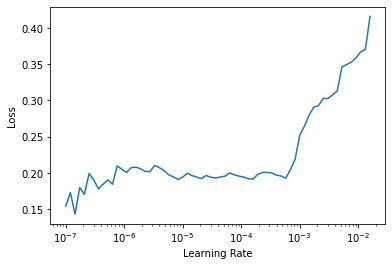

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.186666,0.177030,0.954685,0.913298,05:16
1,0.181785,0.174909,0.955124,0.914104,05:15
2,0.172048,0.180928,0.954543,0.913039,05:15
3,0.187276,0.188788,0.949879,0.904543,05:15


Better model found at epoch 0 with valid_loss value: 0.17702969908714294.


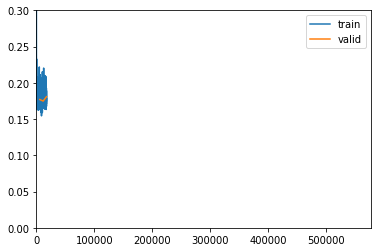

Better model found at epoch 1 with valid_loss value: 0.1749090552330017.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_UNet_resnet18_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1749090552330017,0.9551244475596276,0.9141035459475287]



---


Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
del learn
learn = unet_learner(trainDLS, resnet18, metrics=[Dice(),JaccardCoeff()], wd=1e-1).to_fp16()
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/UNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

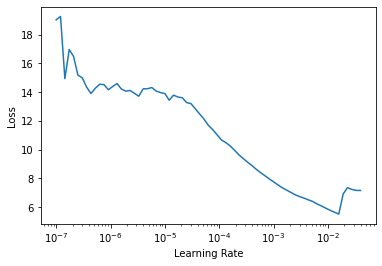

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.281315,0.315309,0.939035,0.885076,04:36
1,0.227637,0.276907,0.943947,0.893845,04:37
2,0.232494,0.277437,0.939556,0.886003,04:38
3,0.209853,0.214874,0.949450,0.903764,04:38
4,0.211922,0.193974,0.951087,0.906737,04:39
5,0.225279,0.198388,0.950356,0.905408,04:39
6,0.197624,0.193944,0.948111,0.901342,04:38


Better model found at epoch 0 with valid_loss value: 0.3153093159198761.


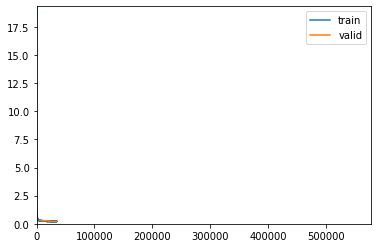

Better model found at epoch 1 with valid_loss value: 0.2769069969654083.
Better model found at epoch 3 with valid_loss value: 0.21487390995025635.
Better model found at epoch 4 with valid_loss value: 0.19397397339344025.
No improvement since epoch 4: early stopping


In [ ]:
name = "model_UNet_resnet18_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.19397397339344025,0.9510874755056232,0.9067366947154057]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

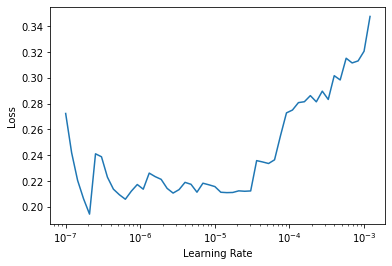

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.210971,0.200582,0.952065,0.908516,05:19
1,0.222231,0.189015,0.952517,0.909338,05:20
2,0.202194,0.186683,0.952792,0.909840,05:19
3,0.205969,0.198151,0.951306,0.907134,05:20
4,0.208643,0.184584,0.952810,0.909873,05:20
5,0.195965,0.189139,0.950831,0.906271,05:20
6,0.204667,0.180186,0.954333,0.912654,05:21
7,0.188651,0.177716,0.954458,0.912883,05:21
8,0.192465,0.195462,0.948113,0.901344,05:20
9,0.181122,0.173557,0.955332,0.914483,05:20


Better model found at epoch 0 with valid_loss value: 0.20058245956897736.


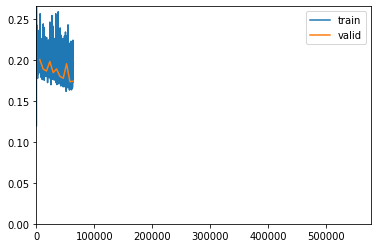

Better model found at epoch 1 with valid_loss value: 0.18901453912258148.
Better model found at epoch 2 with valid_loss value: 0.18668261170387268.
Better model found at epoch 4 with valid_loss value: 0.18458421528339386.
Better model found at epoch 6 with valid_loss value: 0.1801861673593521.
Better model found at epoch 7 with valid_loss value: 0.1777162253856659.
Better model found at epoch 9 with valid_loss value: 0.17355746030807495.
No improvement since epoch 9: early stopping


In [ ]:
name = "model_UNet_resnet18_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_UNet_resnet18_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.17355746030807495,0.9553317394620989,0.9144833585450345]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_da_wd2")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.22396178543567657,0.9454814509668636,0.8966001137047364]

Comparación de resultado buscado contra resultado obtenido.

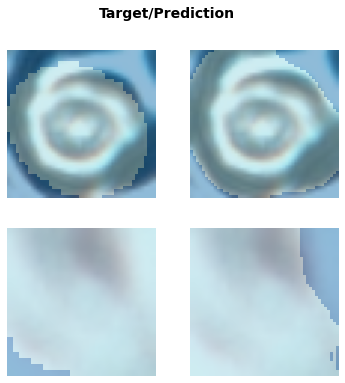

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.2349056750535965,0.940704495877484,0.8880472844607522]

Comparación de resultado buscado contra resultado obtenido.

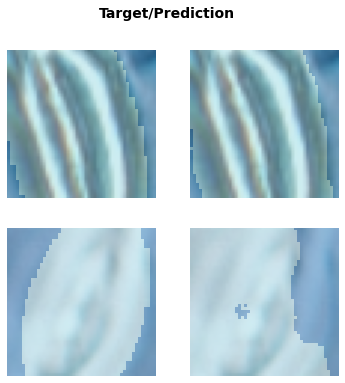

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_da_wd1")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [1.300247311592102,0.815984688626768,0.6891673450408181]

Comparación de resultado buscado contra resultado obtenido.

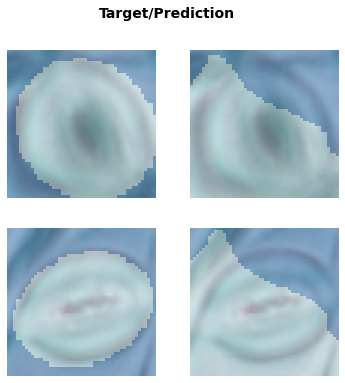

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.969447135925293,0.7736523796885435,0.6308589562004111]

Comparación de resultado buscado contra resultado obtenido.

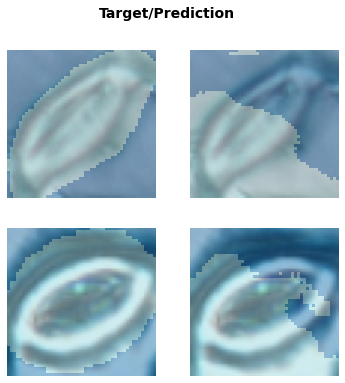

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.6716249585151672,0.7760341491283171,0.6340325169821052]

Comparación de resultado buscado contra resultado obtenido.

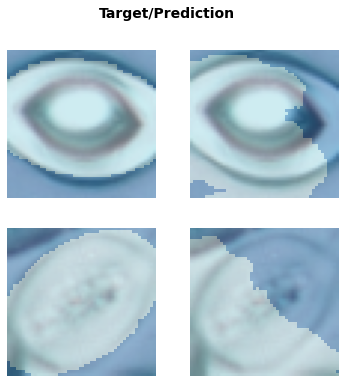

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.8258674144744873,0.7219972420102261,0.5649418496920046]

Comparación de resultado buscado contra resultado obtenido.

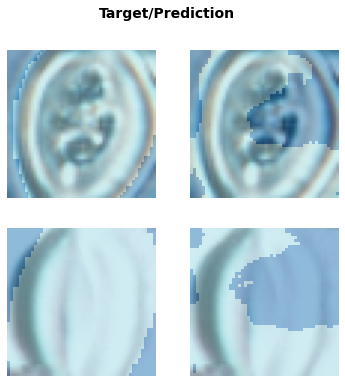

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.4608286917209625,0.8905339048129505,0.8026688771077873]

Comparación de resultado buscado contra resultado obtenido.

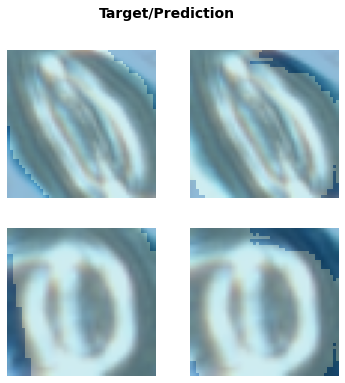

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_UNet_resnet18_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [1.0912110805511475,0.7354920502894526,0.5816428836669716]

Comparación de resultado buscado contra resultado obtenido.

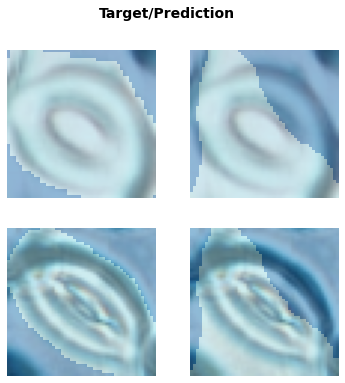

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [20]:
learn.load("model_UNet_resnet18_da_wd2_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.23490580916404724,0.9407046206635411,0.8880475068746142]

In [21]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [ ]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/UNet/model_UNet_resnet18.pkl")